In [ ]:
CLUSTERING AND HEAPMAP EXAMPLE WITH SINGAPUR DATA

In [1]:
import math
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from IPython.display import clear_output
import kaleidoimport pysal
import seaborn
import contextily
import geopandas
import requests
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import matplotlib.pyplot as plt
import hvplot.pandas 
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from holoviews import dim
import warnings
warnings.filterwarnings("ignore")

For dataset sizes purposes, we choose to focus only on one month (September 2014).

In [3]:
singapore = pd.read_csv('/Users/avaisman/tmp/DataMisc/singaporedates.csv')
singapore

,trj_id,driving_mode,osname,rawlat,rawlng,speed,bearing,accuracy,geom,time
0,70014,car,android,1.342326,103.888969,18.910000,248,3.9,0101000020560D000002BB2F3E29B2E0408E783E35A49A...,2019-04-11 02:40:36
1,73573,car,android,1.321781,103.856366,17.719076,44,4.0,0101000020560D00000B41A8973FD9DD4093E5F4C1AB7E...,2019-04-18 12:17:03
2,75567,car,android,1.327088,103.861273,14.021548,34,3.9,0101000020560D0000F3CD38E2C461DE4024A5D6E906C8...,2019-04-13 09:37:06
3,1410,car,android,1.262482,103.823794,13.026521,181,4.0,0101000020560D000098AF6EB5FF4EDA40061E3D521896...,2019-04-20 05:41:33
4,4354,car,android,1.283799,103.807210,14.812943,93,3.9,0101000020560D00004C235CE29581D8408C54415860E3...,2019-04-18 12:48:17
...,...,...,...,...,...,...,...,...,...,...
3034548,67126,car,android,1.349722,103.792840,18.255438,93,6.0,0101000020560D0000E1D97282CFF1D6405B352DF7DF00...,2019-04-11 10:27:17
3034549,11786,car,android,1.386651,103.774858,23.341484,352,6.0,0101000020560D0000D2E47D7986FDD44056B5BCBD4DFF...,2019-04-14 15:25:52
3034550,21686,car,ios,1.329604,103.822454,23.468313,111,5.0,0101000020560D0000C46B5C07BA29DA405B1C3176CBEA...,2019-04-21 02:15:14
3034551,70139,car,android,1.322202,103.886999,20.248346,266,6.0,0101000020560D0000E272BD4FC496E040CA604CF47F84...,2019-04-19 16:58:11


**One line in the dataset corresponds to one pick-up request from a client.**

## 2. Preprocessing of the data

### 2.1. Dates and time basic preprocessing

In [4]:
%%time

SAMPLE_SIZE = 300000
# this cell can take a few minutes to run dependingon the sample size

data = singapore.drop('geom', axis = 1) # drop unuseful column
data = data.sample(SAMPLE_SIZE, random_state = 0) # data sampling for faster computing

# datetime processings
data['time'] = pd.to_datetime(data['time'])
data['day'] = data['time'].dt.day
data['dayofweek'] = data['time'].dt.dayofweek
data['hour'] = data['time'].dt.hour
data['Date/Hour'] = data['time'].dt.floor('H') # Drop the minutes/seconds/level of precision
data['DayOfWeek'] = data['time'].dt.strftime('%A')

# Convert timestamps to string in order to be able to use it as labels in figures
data['Hour'] = data['Date/Hour'].dt.strftime('%H:%M:00')
data['DayOfWeek/Hour'] = data['Date/Hour'].dt.strftime('%A-%H:%M:00') 
data['Date/Hour'] = data['Date/Hour'].dt.strftime('%Y-%m-%d-%H:%M:00')

# Order the values to correspond to the order of looping for vizualisations
data = data.sort_values(['hour','dayofweek'], ascending = [True,True]) 

data

CPU times: user 2.3 s, sys: 132 ms, total: 2.43 s
Wall time: 2.49 s


,trj_id,driving_mode,osname,rawlat,rawlng,speed,bearing,accuracy,time,day,dayofweek,hour,Date/Hour,DayOfWeek,Hour,DayOfWeek/Hour
2394678,83673,car,ios,1.329233,103.857045,21.560360,77,12.0,2019-04-22 00:24:03,22,0,0,2019-04-22-00:00:00,Monday,00:00:00,Monday-00:00:00
15705,79816,car,android,1.281479,103.823658,0.000000,7,3.0,2019-04-15 00:45:07,15,0,0,2019-04-15-00:00:00,Monday,00:00:00,Monday-00:00:00
833730,75452,car,ios,1.434352,103.847038,18.441412,316,12.0,2019-04-15 00:32:16,15,0,0,2019-04-15-00:00:00,Monday,00:00:00,Monday-00:00:00
1113906,72598,car,android,1.389633,103.760450,25.754568,72,3.9,2019-04-22 00:48:42,22,0,0,2019-04-22-00:00:00,Monday,00:00:00,Monday-00:00:00
2466129,364,car,ios,1.377404,103.927905,21.498463,104,8.0,2019-04-22 00:32:47,22,0,0,2019-04-22-00:00:00,Monday,00:00:00,Monday-00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553151,41521,car,ios,1.328341,103.910932,20.559999,61,10.0,2019-04-14 23:17:37,14,6,23,2019-04-14-23:00:00,Sunday,23:00:00,Sunday-23:00:00
2287435,60813,car,android,1.328435,103.839764,27.780739,241,8.0,2019-04-21 23:54:05,21,6,23,2019-04-21-23:00:00,Sunday,23:00:00,Sunday-23:00:00
1779749,46414,car,ios,1.343195,103.856441,19.475945,269,16.0,2019-04-21 23:12:46,21,6,23,2019-04-21-23:00:00,Sunday,23:00:00,Sunday-23:00:00
554990,76810,car,ios,1.339318,103.944337,21.021547,230,5.0,2019-04-21 23:41:46,21,6,23,2019-04-21-23:00:00,Sunday,23:00:00,Sunday-23:00:00


### 2.2. Data Exploration - Choosing the timeframes

Information that could be interesting for Uber is the localization of clusters condensing significant part of the demand, for a given timeframe. 
It remains to be determined how we mesh the time and choose the timeframe to visualize our clusters.  
To choose the best timeframe, we first observe the overall evolution in time of the number of pick-up requests by clients. 

In [5]:
# Get the first monday in datetime format to begin the weekly x-axis grid

mondays_dt = data[data['DayOfWeek/Hour'].str.contains('Monday')]['time'].dt.date
first_monday_dt = mondays_dt.loc[mondays_dt.index[0]]
first_monday_dt

datetime.date(2019, 4, 22)

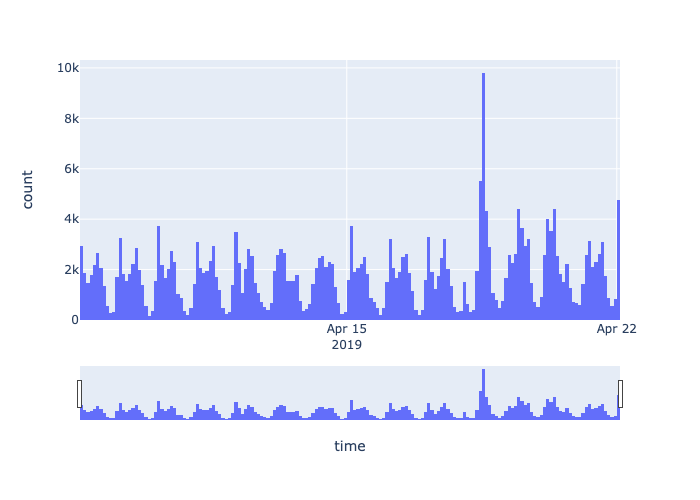

In [6]:
# Show evolution of demand as a function of time

fig = px.histogram(data, x = 'time')
fig.update_xaxes(tick0 = first_monday_dt, dtick = 86400000*7, showgrid=True, # A one-day tick width is 86400000 according to the documentation => we choose one tick = one week
                 rangeslider = go.layout.xaxis.Rangeslider(visible = True)) 

file_name = 'Evolution_of_demand_over_time.html'
dir_name = 'SingaporeFigs'
path = f"{dir_name}/{file_name}"
fig.write_html(path) # saving interactive figure in html file
fig.show('png') # showing non-interactive preview for github

In [ ]:
We hence choose the {day of week, hour} combination as the
timeframe used to split our data in order to run a clustering 
for each timeframe. Each clustering will be fed only with 
geolocalization data (latitude and longitude)

In [7]:
data.sort_values('rawlat')
 
data.head()

,trj_id,driving_mode,osname,rawlat,rawlng,speed,bearing,accuracy,time,day,dayofweek,hour,Date/Hour,DayOfWeek,Hour,DayOfWeek/Hour
2394678,83673,car,ios,1.329233,103.857045,21.560360,77,12.0,2019-04-22 00:24:03,22,0,0,2019-04-22-00:00:00,Monday,00:00:00,Monday-00:00:00
15705,79816,car,android,1.281479,103.823658,0.000000,7,3.0,2019-04-15 00:45:07,15,0,0,2019-04-15-00:00:00,Monday,00:00:00,Monday-00:00:00
833730,75452,car,ios,1.434352,103.847038,18.441412,316,12.0,2019-04-15 00:32:16,15,0,0,2019-04-15-00:00:00,Monday,00:00:00,Monday-00:00:00
1113906,72598,car,android,1.389633,103.760450,25.754568,72,3.9,2019-04-22 00:48:42,22,0,0,2019-04-22-00:00:00,Monday,00:00:00,Monday-00:00:00
2466129,364,car,ios,1.377404,103.927905,21.498463,104,8.0,2019-04-22 00:32:47,22,0,0,2019-04-22-00:00:00,Monday,00:00:00,Monday-00:00:00


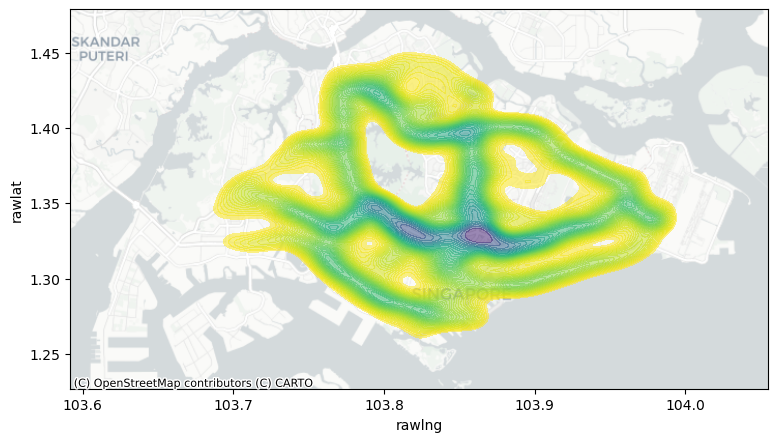

In [8]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Generate and add KDE with a shading of 50 gradients
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
seaborn.kdeplot(
    x="rawlng",
    y="rawlat",
    data=data,
    n_levels=50,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)
# Add basemap

#contextily.add_basemap(
#    joint_axes.ax_joint,
#    crs="EPSG:4813",
#    source=contextily.providers.CartoDB.Positron   
contextily.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.Positron
)
# Remove axes
#ax.set_axis_off()
plt.savefig("/Users/avaisman/tmp/singapore.svg", format='svg')

In [14]:
columns_to_keep = ['rawlat', 'rawlng', 'DayOfWeek/Hour']
data = data[columns_to_keep]
data

,rawlat,rawlng,DayOfWeek/Hour
2394678,1.329233,103.857045,Monday-00:00:00
15705,1.281479,103.823658,Monday-00:00:00
833730,1.434352,103.847038,Monday-00:00:00
1113906,1.389633,103.760450,Monday-00:00:00
2466129,1.377404,103.927905,Monday-00:00:00
...,...,...,...
1553151,1.328341,103.910932,Sunday-23:00:00
2287435,1.328435,103.839764,Sunday-23:00:00
1779749,1.343195,103.856441,Sunday-23:00:00
554990,1.339318,103.944337,Sunday-23:00:00


### 2.3. Distances preprocessings

In [ ]:
As chosen before, the only features that we will feed to our clustering algorithms are latitude and longitude.
In this project, we want to reason on road distances, and we want to assign the exact same importance to the
distance travelled in a direction than in another.
 
We will not use directly the latitude and longitude values, 
but their equivalent in distance.  

In [16]:
# Create new features that represent distances in 100 kilometers unit 
# (we use the 100km unit rather than the km unit to avoid feeding too big numbers to the algorithms) 
data['x'] = data['rawlng'] * 111.320 * np.cos(np.radians(data['rawlat'])) / 100                               # transform longitude
data['y'] = data['rawlat'] * 110.574 / 100                                                                 # transform latitude

# Define these 2 features are the ones that will be fed to the clustering algorithms
clustering_features = ['x','y']
data

,rawlat,rawlng,DayOfWeek/Hour,x,y
2394678,1.329233,103.857045,Monday-00:00:00,115.582551,1.469786
15705,1.281479,103.823658,Monday-00:00:00,115.547590,1.416983
833730,1.434352,103.847038,Monday-00:00:00,115.566300,1.586021
1113906,1.389633,103.760450,Monday-00:00:00,115.472162,1.536573
2466129,1.377404,103.927905,Monday-00:00:00,115.659115,1.523050
...,...,...,...,...,...
1553151,1.328341,103.910932,Sunday-23:00:00,115.642564,1.468800
2287435,1.328435,103.839764,Sunday-23:00:00,115.563357,1.468904
1779749,1.343195,103.856441,Sunday-23:00:00,115.581222,1.485225
554990,1.339318,103.944337,Sunday-23:00:00,115.679224,1.480938


### 2.4 Splitting the data along timeframes

In [17]:
# Splitting the data by timeframes : an independant clustering will be run on each timeframe

timeframes = data['DayOfWeek/Hour'].unique()
timeframe_data_list = []
for timeframe in timeframes:
    timeframe_data_list.append(data[data['DayOfWeek/Hour'] == timeframe])
print("Number of timeframes: ", len(timeframe_data_list))
print("Showing some examples:")
timeframe_data_list[:3]

Number of timeframes:  168
Showing some examples:


[           rawlat      rawlng   DayOfWeek/Hour           x         y
 2394678  1.329233  103.857045  Monday-00:00:00  115.582551  1.469786
 15705    1.281479  103.823658  Monday-00:00:00  115.547590  1.416983
 833730   1.434352  103.847038  Monday-00:00:00  115.566300  1.586021
 1113906  1.389633  103.760450  Monday-00:00:00  115.472162  1.536573
 2466129  1.377404  103.927905  Monday-00:00:00  115.659115  1.523050
 ...           ...         ...              ...         ...       ...
 541262   1.364672  103.956160  Monday-00:00:00  115.691174  1.508972
 1125856  1.421103  103.797592  Monday-00:00:00  115.511939  1.571370
 723984   1.279199  103.820537  Monday-00:00:00  115.544219  1.414462
 284879   1.319914  103.779840  Monday-00:00:00  115.497064  1.459482
 2664076  1.340092  103.972956  Monday-00:00:00  115.711038  1.481794
 
 [2335 rows x 5 columns],
            rawlat      rawlng    DayOfWeek/Hour           x         y
 2399528  1.376714  103.929903  Tuesday-00:00:00  115.661371 

In [ ]:
K-Means Clustering

In [ ]:
Choosing the optimal number of clusters.

The only hyperparameter that has to be defined for running a KMeans algorithm is the number of clusters 'k'. 
It can be difficult to find at first sight the number that would be the more adequate, 
and it could vary among timeframes. => We choose to run for each timeframe 9 KMeans algorithm 
(each one with the k hyperparameter between 2 and 10), and for each both the silhouette score
and the WCSS inertia.

The lower the WCSS inertia is, the closer the points of one given cluster are close from each other,
we want to find an optimal 'k' with a low inertia (to allow drivers not to have to drive too far
away to find clients).

Also, the higher the silhouette score is, the better the partition between clusters is, we would also 
want to keep this score as high as possible.
=> To get the better compromise between the 2, we will scale these 2 characteristics and 
take for each timeframe the 'k' that maximizes the score = scaled silhouette score -
scaled WCSS inertia, and keep the corresponding k hyperparameter.

In [18]:
# Identifying for each timeframe the better number of clusters to use

print(f"Finding the optimum k hyperparameter for each of the {len(timeframe_data_list)} timeframes :")

timeframes_nb = len(timeframe_data_list)
progress_percents_to_display = list(range(5, 100, 5))
indexes_to_display_progress = np.ceil([timeframes_nb * percent / 100 for percent in progress_percents_to_display])

optimum_k_list = []
sc = StandardScaler()

for i in range(timeframes_nb):
    wcss_list = []
    sil_list = []
    k_list = []
    for k in range(2,10+1):
        X = timeframe_data_list[i][clustering_features]
        kmeans = KMeans(n_clusters = k, random_state = 0)
        kmeans.fit(X)
        wcss_list.append(kmeans.inertia_)
        sil_list.append(silhouette_score(X, kmeans.predict(X)))
        k_list.append(k)
        
    k_choice = pd.DataFrame({'k':k_list, 'WCSS':wcss_list, 'Silhouette Score':sil_list}).set_index('k')
    k_choice_scaled = sc.fit_transform(k_choice)
    k_choice['score'] = k_choice_scaled[:,1] - k_choice_scaled[:,0]
    optimum_k = k_choice.index[k_choice['score'].argmax()]
    optimum_k_list.append(optimum_k)

    if i+1 in indexes_to_display_progress:  
        print(int(((i+1)/timeframes_nb) * 100), "% complete", end = '\r')  # display progress percentage every 5%
print("Done !                ")

Finding the optimum k hyperparameter for each of the 168 timeframes :
Done !                


#### 3.1.2. Computing the algorithm

In [19]:
# Run optimized KMeanss on each timeframe
 
print(f"Fitting one KMeans on each of the {len(timeframe_data_list)} timeframes :") 

for i in range(timeframes_nb):
    kmeans = KMeans(n_clusters = optimum_k_list[i], random_state = 0)
    kmeans.fit(timeframe_data_list[i][clustering_features])
    timeframe_data_list[i]['cluster'] = kmeans.labels_
    timeframe_data_list[i] = timeframe_data_list[i].sort_values('cluster')
    if i+1 in indexes_to_display_progress:  
        print(int(((i+1)/timeframes_nb) * 100), "% complete", end = '\r')  # display progress percentage every 5%
print("Done !                 ")

Fitting one KMeans on each of the 168 timeframes :
Done !                 


#### 3.1.3. Processings for vizualisation

In [21]:
timeframe_summary_list = []

for timeframe_data in timeframe_data_list:

    # Create a dataframe summarizing the number of pick-up requests for each cluster in the timeframe, and the % of the timeframe demand it represents:
    timeframe_demand = len(timeframe_data)
    clusters_size = timeframe_data.groupby(['DayOfWeek/Hour', 'cluster']).count()['rawlat'].rename('count').reset_index(drop = False)
    clusters_size['%_of_timeframe_demand'] = (clusters_size['count'] / timeframe_demand * 100).astype(int)
    
    # Merge the information in each timeframe:
    timeframe_summary = timeframe_data.merge(clusters_size, on = ['DayOfWeek/Hour', 'cluster'])
    
    # Create a column with the text to display for each cluster in the timeframe: 
    timeframe_summary['cluster / % of demand'] = '#' + timeframe_summary['cluster'].astype(str) + ' / ' + timeframe_summary['%_of_timeframe_demand'].astype(str) + '%'
    
    # Splitting the timeframe identification in two (day of week, hour) to monitor one in the subplots and the other in the slider in the plotly figure
    timeframe_summary['DayOfWeek'] = timeframe_summary['DayOfWeek/Hour'].str.partition('-')[0]
    timeframe_summary['Hour'] = timeframe_summary['DayOfWeek/Hour'].str.partition('-')[2]
    
    timeframe_summary_list.append(timeframe_summary)

In [ ]:
print("Example for a given timeframe :")
timeframe_example = timeframe_summary_list[50]
display(timeframe_example)
fig = px.scatter_mapbox(timeframe_example, lat = 'rawlat', lon = 'rawlng', 
                      mapbox_style="carto-positron", 
                      color = timeframe_example['cluster / % of demand'].astype(str), 
                      height = 700, zoom = 10
                     )
#fig.show('png')



fig.update_layout(height = 700, title_text = "KMeans clustering : Hot-zones by day of week and hour", legend_title_text = "#Cluster -- % of timeframe demand")
file_name = 'KMeans_clustering_tf.html'
dir_name = 'SingaporeFigs'
path = f"{dir_name}/{file_name}"
fig.write_html(path) # Saving interactive figure in html file
print(f'Figure created in {path}')
fig.show()

In [ ]:
Final visualizations

In [ ]:
# Create one subplot per day of week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
figs = sp.make_subplots(rows = int(math.ceil(len(days_of_week)/3)), cols = 3, subplot_titles = days_of_week, 
                        specs = [[{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {}, {}]],
                        horizontal_spacing = 0.03, vertical_spacing = 0.03)

# Set default mapbox display settings
default_mapbox_dict = {'center': {'lat': 1.3412559, 'lon': 103.8},
                       'style': 'carto-positron',
                       'zoom': 8.5
                      }

# Initialize each day mapbox
for day_index in range(len(days_of_week)):
    figs.update_layout({f'mapbox{day_index+1}' : default_mapbox_dict})

# Slider initialization
slider_dict = {'active': 0,
               'currentvalue': {'prefix': 'hour='},
               'len': 0.9,
               'pad': {'b': 10, 't': 30},
               'steps': []
              }

# Initialize timeframe, traces list

timeframe_index = 0
traces_hour_index = [] # initialize a list which will associate to each trace its corresponding hour index for later use in interactive mask (slider)

# Fill the data for each trace (1 trace per different {hour, day, cluster} combination existing in the data)
# 1. Loop on frames (hours)

hour_names = ["{:0>2d}:00:00".format(hour_index) for hour_index in range(24)] 
for hour_index in range(24):

    # 2. Loop on subplots (days of week)

    for day_index, day in enumerate(days_of_week):
        subplot_data = timeframe_summary_list[timeframe_index]
        row_number = i//3 + 1
        col_number = i%3 + 1

        # 3. Loop on traces (clusters)

        for cluster in subplot_data['cluster'].unique():
            cluster_data = subplot_data[subplot_data['cluster']==cluster]
            if len(cluster_data['cluster / % of demand'].unique()) != 0:
                cluster_name = cluster_data['cluster / % of demand'].unique()[0]
            else: 
                cluster_name = 'no cluster found'
            data_dict = {
                'type' : 'scattermapbox',
                'text': hour_names[hour_index],
                'hoverinfo': 'all',
                'name': cluster_name,
                'subplot': f'mapbox{day_index+1}',
                'lat' : subplot_data['rawlat'][subplot_data['cluster'] == cluster],
                'lon' : subplot_data['rawlng'][subplot_data['cluster'] == cluster],
                'legendgrouptitle' : {'text' : day},
                'legendgroup' : day,
                'showlegend' : True,
                'visible' : False # set each trace default to invisible since the slider will set which trace is visible
            }
            if hour_index == 0:
                data_dict['visible'] = True # Set the traces of the first hour default to visible
            figs.add_trace(data_dict)
            traces_hour_index.append(hour_index)
            print(f"Trace created for Hour : {hour_index}, Day : {day}, Cluster : {cluster}")
            clear_output(wait = True)
        timeframe_index += 1

# Create steps of the slider

for hour_index in range(24):
    mask = [True if x == hour_index else False for x in traces_hour_index]
    step = {'args': [{'visible': mask},{'showlegend' : mask}],
            'label': hour_names[hour_index],
            'method': 'update'}
    slider_dict['steps'].append(step)
figs.layout.sliders = [slider_dict]

# Plot and save figure

figs.update_layout(height = 700, title_text = "KMeans clustering : Hot-zones by day of week and hour", legend_title_text = "#Cluster -- % of timeframe demand")
file_name = 'KMeans_clustering_alldays.html'
dir_name = 'SingaporeFigs'
path = f"{dir_name}/{file_name}"
figs.write_html(path) # Saving interactive figure in html file
print(f'Figure created in {path}')
#figs.show('png') # Showing non-interactive preview for github
figs.show()

In [ ]:
DBSCAN Clustering

In [ ]:
For this reason, for our DBSCANs, we choose an epsilon radius of 0.5km.  

We set the min_samples parameter at 1% of the overall average demand by timeframe, 
which is a proportion 10x higher than the proportion of the city surface 
covered by a single epsilon-area.  

In [41]:
# Set the DBSCAN constant hyperparameters

eps = 0.5/100 # corresponds to 0.5km radius
metric = 'euclidean'  
min_samples = int(0.01 * np.mean([len(timeframe_data) for timeframe_data in timeframe_data_list])) # defining min_samples as a 1% of the overall average demand by timeframe

# Run distinct DBSCANs on each timeframe
 
print(f"Fitting one DBSCAN on each of the {len(timeframe_data_list)} timeframes (min_samples = {min_samples}) :") 
timeframes_nb = len(timeframe_data_list)
progress_percents_to_display = list(range(10, 100, 10))
indexes_to_display_progress = np.ceil([timeframes_nb * percent / 100 for percent in progress_percents_to_display])

for i in range(timeframes_nb):
    dbscan = DBSCAN(eps = eps, min_samples = min_samples, metric = metric)
    dbscan.fit(timeframe_data_list[i][clustering_features])
    timeframe_data_list[i]['cluster'] = dbscan.labels_
    timeframe_data_list[i] = timeframe_data_list[i].sort_values('cluster')
    if i+1 in indexes_to_display_progress:  
        print(int(((i+1)/timeframes_nb) * 100), "% complete", end = '\r')  # display progress percentage every 10%
print("Done !          ")

Fitting one DBSCAN on each of the 168 timeframes (min_samples = 17) :
Done !          


#### 3.2.2. Processings for vizualisation

In [42]:
timeframe_summary_list = []

for timeframe_data in timeframe_data_list:

    # Create a dataframe summarizing the number of pick-up requests for each cluster in the timeframe, and the % of the timeframe demand it represents:
    timeframe_demand = len(timeframe_data)
    clusters_size = timeframe_data.groupby(['DayOfWeek/Hour', 'cluster']).count()['rawlat'].rename('count').reset_index(drop = False)
    clusters_size['%_of_timeframe_demand'] = (clusters_size['count'] / timeframe_demand * 100).astype(int)
    
    # Merge the information in each timeframe:
    timeframe_summary = timeframe_data.merge(clusters_size, on = ['DayOfWeek/Hour', 'cluster'])
    
    # Create a column with the text to display for each cluster in the timeframe: 
    timeframe_summary['cluster / % of demand'] = '#' + timeframe_summary['cluster'].astype(str) + ' / ' + timeframe_summary['%_of_timeframe_demand'].astype(str) + '%'
    
    # Splitting the timeframe identification in two (day of week, hour) to monitor one in the subplots and the other in the slider in the plotly figure
    timeframe_summary['DayOfWeek'] = timeframe_summary['DayOfWeek/Hour'].str.partition('-')[0]
    timeframe_summary['Hour'] = timeframe_summary['DayOfWeek/Hour'].str.partition('-')[2]
    
    timeframe_summary_list.append(timeframe_summary)

In [ ]:
print("Example for a given timeframe (without hiding outliers) :")
timeframe_example = timeframe_summary_list[50]
display(timeframe_example)
fig1 = px.scatter_mapbox(timeframe_example, lat = 'rawlat', lon = 'rawlng', 
                      mapbox_style="carto-positron", 
                      color = timeframe_example['cluster / % of demand'].astype(str), 
                      height = 700, zoom = 10
                     )
fig1.update_layout(height = 700, title_text = "DBSCAN clustering : Hot-zones by day of week and hour", legend_title_text = "#Cluster -- % of timeframe demand")
file_name = 'DBSCAN_clustering.html'
dir_name = 'SingaporeFigs'
path = f"{dir_name}/{file_name}"
fig1.write_html(path) # Saving interactive figure in html file
print(f'Figure created in {path}')
fig1.show('png')

In [ ]:
Final visualizations

In [ ]:
# Create one subplot per day of week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
figs = sp.make_subplots(rows = int(math.ceil(len(days_of_week)/3)), cols = 3, subplot_titles = days_of_week, 
                        specs = [[{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {}, {}]],
                        horizontal_spacing = 0.03, vertical_spacing = 0.03)

# Set default mapbox display settings
default_mapbox_dict = {'center': {'lat': 1.3412559, 'lon': 103.889029},
                       'style': 'carto-positron',
                       'zoom': 8.5
                      }

# Initialize each day mapbox
for day_index in range(len(days_of_week)):
    figs.update_layout({f'mapbox{day_index+1}' : default_mapbox_dict})

# Slider initialization
slider_dict = {'active': 0,
               'currentvalue': {'prefix': 'hour='},
               'len': 0.9,
               'pad': {'b': 10, 't': 30},
               'steps': []
              }

# Initialize timeframe, traces list

timeframe_index = 0
traces_hour_index = [] # initialize a list which will associate to each trace its corresponding hour index for later use in interactive mask (slider)

# Fill the data for each trace (1 trace per different {hour, day, cluster} combination existing in the data)
# 1. Loop on frames (hours)

hour_names = ["{:0>2d}:00:00".format(hour_index) for hour_index in range(24)] 
for hour_index in range(24):

    # 2. Loop on subplots (days of week)

    for day_index, day in enumerate(days_of_week):
        subplot_data = timeframe_summary_list[timeframe_index]
        hide_outliers_mask = subplot_data['cluster']!=-1 
        subplot_data = subplot_data[hide_outliers_mask] # hide outliers on the maps
        row_number = i//3 + 1
        col_number = i%3 + 1

        # 3. Loop on traces (clusters)

        for cluster in subplot_data['cluster'].unique():
            cluster_data = subplot_data[subplot_data['cluster']==cluster]
            if len(cluster_data['cluster / % of demand'].unique()) != 0:
                cluster_name = cluster_data['cluster / % of demand'].unique()[0]
            else: 
                cluster_name = 'no cluster found'
            data_dict = {
                'type' : 'scattermapbox',
                'text': hour_names[hour_index],
                'hoverinfo': 'all',
                'name': cluster_name,
                'subplot': f'mapbox{day_index+1}',
                'lat' : subplot_data['rawlat'][subplot_data['cluster'] == cluster],
                'lon' : subplot_data['rawlng'][subplot_data['cluster'] == cluster],
                'legendgrouptitle' : {'text' : day},
                'legendgroup' : day,
                'showlegend' : True,
                'visible' : False # set each trace default to invisible since the slider will set which trace is visible
            }
            if hour_index == 0:
                data_dict['visible'] = True # Set the traces of the first hour default to visible
            figs.add_trace(data_dict)
            traces_hour_index.append(hour_index)
            print(f"Trace created for Hour : {hour_index}, Day : {day}, Cluster : {cluster}")
            clear_output(wait = True)
        timeframe_index += 1

# Create steps of the slider

for hour_index in range(24):
    mask = [True if x == hour_index else False for x in traces_hour_index]
    step = {'args': [{'visible': mask},{'showlegend' : mask}],
            'label': hour_names[hour_index],
            'method': 'update'}
    slider_dict['steps'].append(step)
figs.layout.sliders = [slider_dict]

# Plot and save figure

figs.update_layout(height = 700, title_text = "DBSCAN clustering : Hot-zones by day of week and hour", legend_title_text = "#Cluster -- % of timeframe demand")
file_name = 'DBSCAN_clustering_alldays.html'
dir_name = 'SingaporeFigs'
path = f"{dir_name}/{file_name}"
figs.write_html(path) # saving interactive figure in html file
print(f'Figure created in {path}')
figs.show('png') # showing non-interactive preview for github